# An exercise in scam prediction
### Dr Jose M Albornoz
### September 9th 2022

#### Problem: Retail bank identifying scam transactions

A large retail bank is aiming to better identify scam transactions. The dataset they provide contains a sample of information about historical transactions, the customers making the transactions and whether the transaction was fraudulent. They currently use a simple rules-based approach using a subset of the features in the dataset to flag transactions, but they are open to more complex solutions that can give better predictive power while remaining explainable.

The primary stakeholder on the client side is the Head of Fraud Operations, who has a strong commercial background but little understanding of data science or machine learning. With them in the meeting will be a Senior Data Analyst who will be evaluating the proposal from a technical perspective. Your presentation should be pitched to be relevant for both parties.

The client’s goal is to understand the following:  
- How can we more effectively identify scam transactions?
- What information is most relevant in identifying whether a transaction is a scam?
- Can we use any other data (internal or external) to help us identify whether the likelihood of scam transactions will increase? 
- Are there actions that can be taken to mitigate scam transactions?


# 0.- Import necessary modules

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib import cm
style.use('fivethirtyeight')
%matplotlib inline
plt.rcParams["figure.figsize"] = (8,6)

import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_curve, precision_recall_curve

# maximum number of rdataframe rows and columns displayed
pd.set_option('display.max_rows', 50000)
pd.set_option('display.max_columns', 500)

RANDOM_STATE = 801
pd.options.mode.chained_assignment = None

# 1.- Load dataset
The initial dataset as below contains the potential features provided by the client, and whether the transaction was actually a scam or not in the 'scam' column. 

Consider how best to use this data to develop an initial model and evaluate its predictive power. Explain your modelling choices and results in your presentation (considering the background of the target audience).

In [2]:
scam_data = pd.read_csv('scam_transactions.csv', index_col=0)
scam_data.head()

,Age,Amount Transferred (£k),Weeks since Beneficiary Account Creation,Number of Transactions to Beneficiary,Device Risk,Location,Occupation,Percentage of Account Amount Transferred,Time of Day,Time since last Cyber Awareness message,Time Spent on App (min),Total Amount on Account,Years of Education,Scam
ID,,,,,,,,,,,,,,
0,43,18.481454,2,1,0.115611,Home,Financial Services,16.889842,11.184601,12,5.553583,109.423485,5,0
1,56,2.584866,41,26,0.509994,Home,Other,6.666667,16.532225,13,6.805310,38.772995,5,0
2,47,4.899804,36,28,0.219455,Home,Financial Services,23.034970,20.051155,8,4.048093,21.271153,1,0
3,29,25.567627,45,13,0.126706,Home,Other,12.845499,12.378713,1,5.569381,199.039578,10,0
4,31,11.718018,9,21,0.198031,Home,Other,12.890670,9.667813,20,8.879947,90.903097,11,0


In [3]:
scam_data.shape

(10000, 14)

**CAVEAT:** This is a rather small dataset - the results of this analysis are thus to be considered of an initial exploratory nature.

In [4]:
target_name = "Scam"
data, target = scam_data.drop(columns=target_name), scam_data[target_name]

# 2.- Exploratory Data Analysis

## 2.1.- Target class balance

In [5]:
target.value_counts()

0    9919
1      81
Name: Scam, dtype: int64

In [6]:
target.value_counts()*100/data.shape[0]

0    99.19
1     0.81
Name: Scam, dtype: float64

As seen above, we are dealing with a strongly imbalanced target - this is a common situation in scam and fraud detection applications

## 2.2.- Missing values

In [7]:
data.isnull().sum()

Age                                         0
Amount Transferred (£k)                     0
Weeks since Beneficiary Account Creation    0
Number of Transactions to Beneficiary       0
Device Risk                                 0
Location                                    0
Occupation                                  0
Percentage of Account Amount Transferred    0
Time of Day                                 0
Time since last Cyber Awareness message     0
Time Spent on App (min)                     0
Total Amount on Account                     0
Years of Education                          0
dtype: int64

No missing values are found in the provided dataset

## 2.3.- Categorical vs numerical features

In [8]:
from sklearn.compose import make_column_selector as selector

numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(data)
categorical_columns = categorical_columns_selector(data)

### 2.3.1.- Categorical features

In [9]:
data[categorical_columns].head()

,Location,Occupation
ID,,
0,Home,Financial Services
1,Home,Other
2,Home,Financial Services
3,Home,Other
4,Home,Other


We have two categorical nominal features.

In [10]:
data['Location'].unique()

array(['Home', 'Away'], dtype=object)

In [11]:
data['Location'].value_counts()

Home    8982
Away    1018
Name: Location, dtype: int64

In [12]:
data['Occupation'].unique()

array(['Financial Services', 'Other', 'IT'], dtype=object)

In [13]:
data['Occupation'].value_counts()

Other                 9161
Financial Services     566
IT                     273
Name: Occupation, dtype: int64

From a domain expertise point of view, there are very few values for the 'Occupation" feature - perhaps it would be worthwhile to include a greater level of detail as to the client's occupation.

The good news is that there are no rare categories in "Location" and "Occupation"!

### 2.3.2.- Numerical features

In [14]:
data[numerical_columns].head()

,Age,Amount Transferred (£k),Weeks since Beneficiary Account Creation,Number of Transactions to Beneficiary,Device Risk,Percentage of Account Amount Transferred,Time of Day,Time since last Cyber Awareness message,Time Spent on App (min),Total Amount on Account,Years of Education
ID,,,,,,,,,,,
0,43,18.481454,2,1,0.115611,16.889842,11.184601,12,5.553583,109.423485,5
1,56,2.584866,41,26,0.509994,6.666667,16.532225,13,6.805310,38.772995,5
2,47,4.899804,36,28,0.219455,23.034970,20.051155,8,4.048093,21.271153,1
3,29,25.567627,45,13,0.126706,12.845499,12.378713,1,5.569381,199.039578,10
4,31,11.718018,9,21,0.198031,12.890670,9.667813,20,8.879947,90.903097,11


<AxesSubplot: >

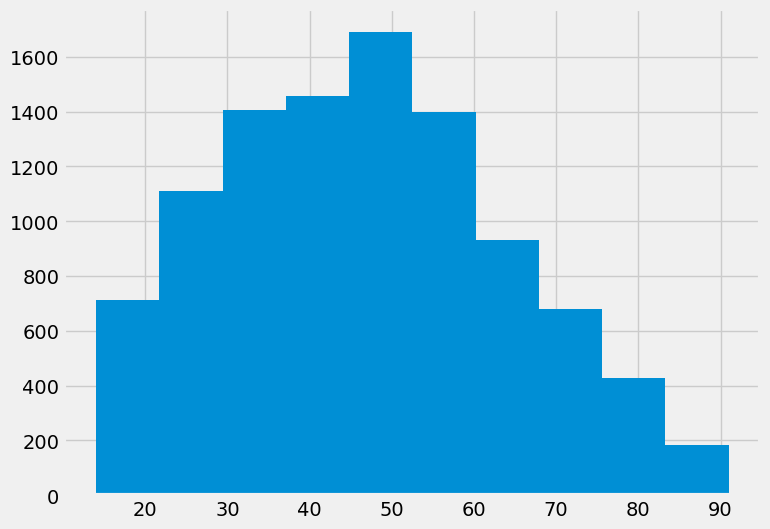

In [15]:
data['Age'].hist()

<AxesSubplot: >

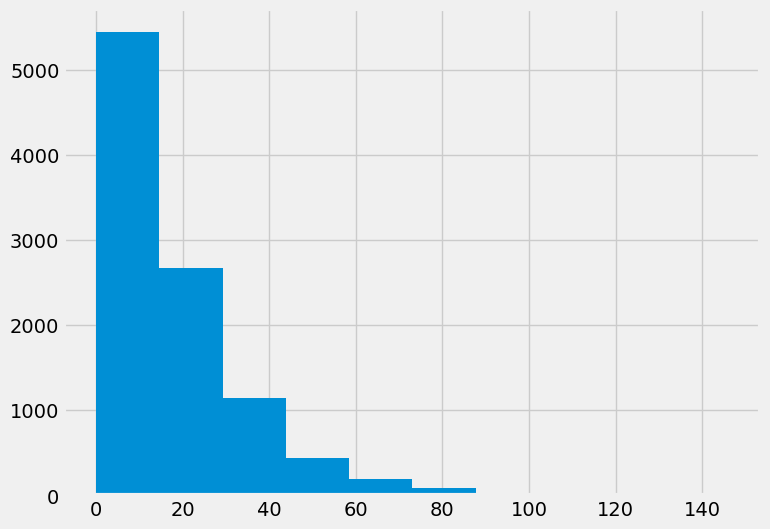

In [16]:
data['Amount Transferred (£k)'].hist()

<AxesSubplot: >

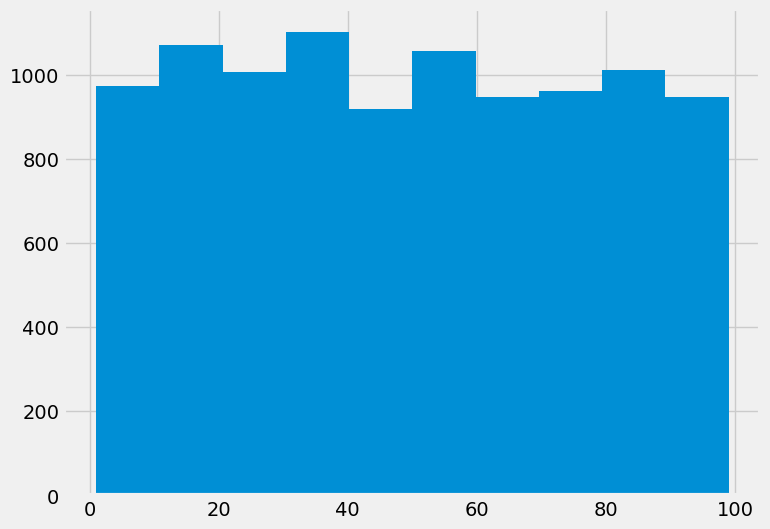

In [17]:
data['Weeks since Beneficiary Account Creation'].hist()

<AxesSubplot: >

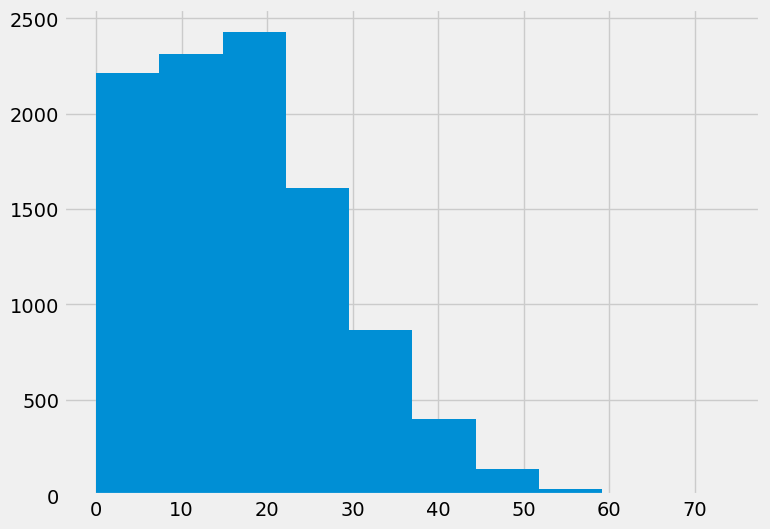

In [18]:
data['Number of Transactions to Beneficiary'].hist()

<AxesSubplot: >

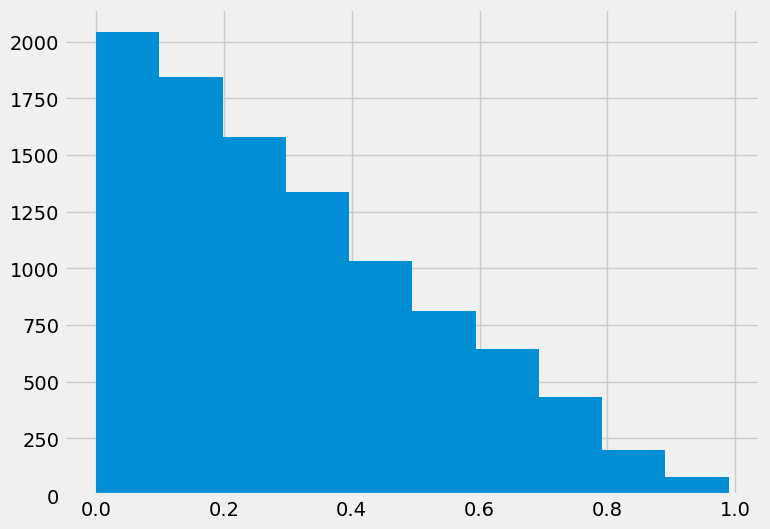

In [19]:
data['Device Risk'].hist()

<AxesSubplot: >

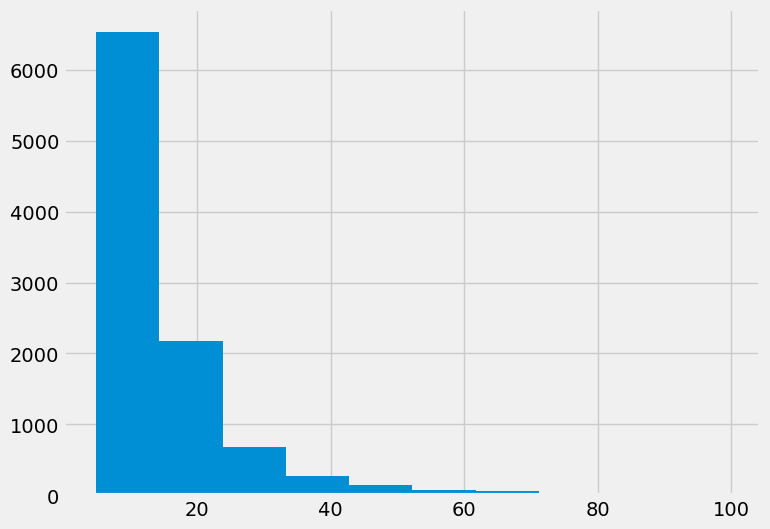

In [20]:
data['Percentage of Account Amount Transferred'].hist()

<AxesSubplot: >

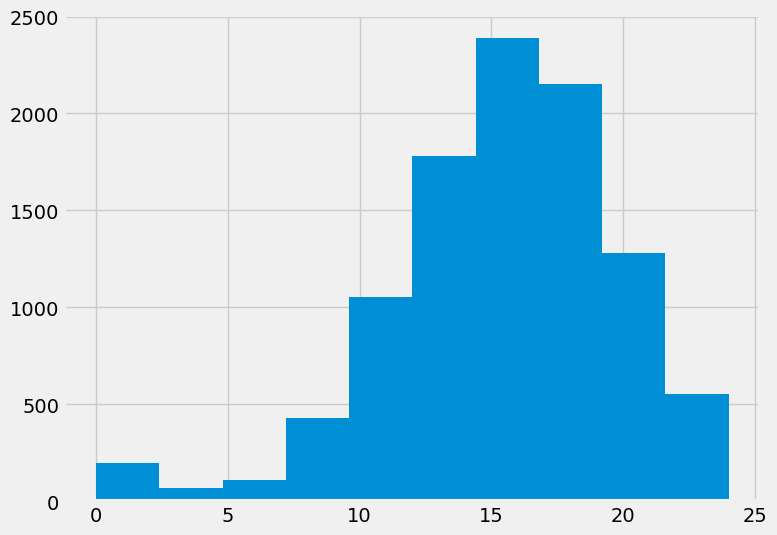

In [21]:
data['Time of Day'].hist()

<AxesSubplot: >

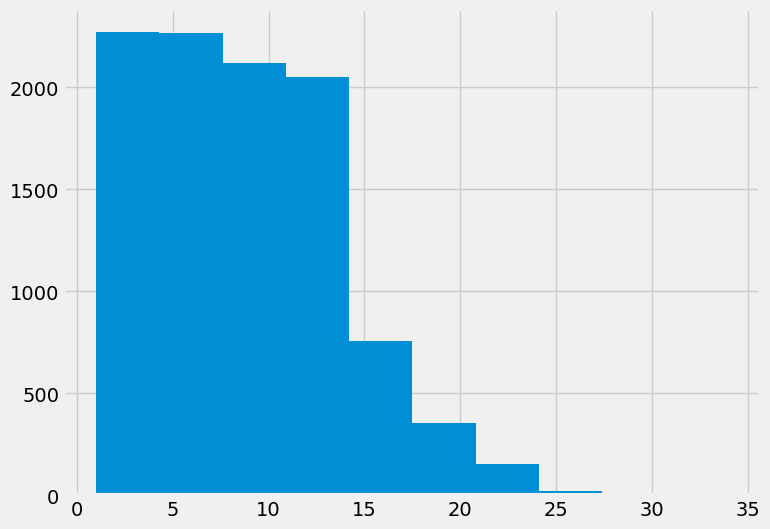

In [22]:
data['Time since last Cyber Awareness message'].hist()

<AxesSubplot: >

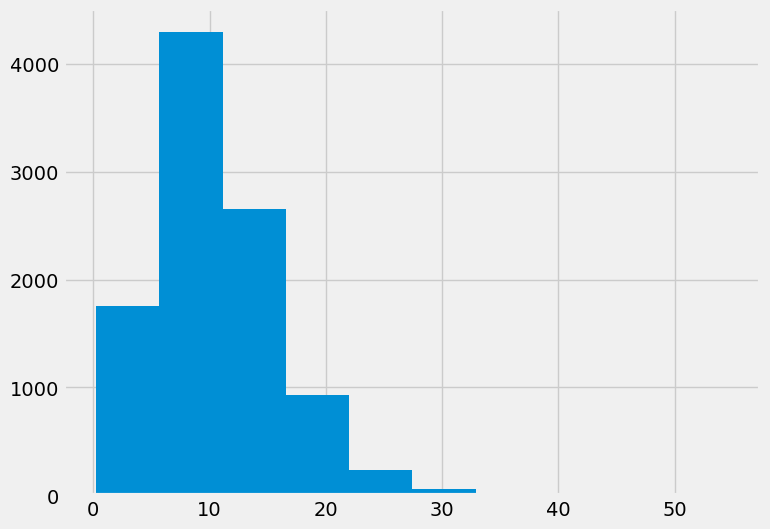

In [23]:
data['Time Spent on App (min)'].hist()

<AxesSubplot: >

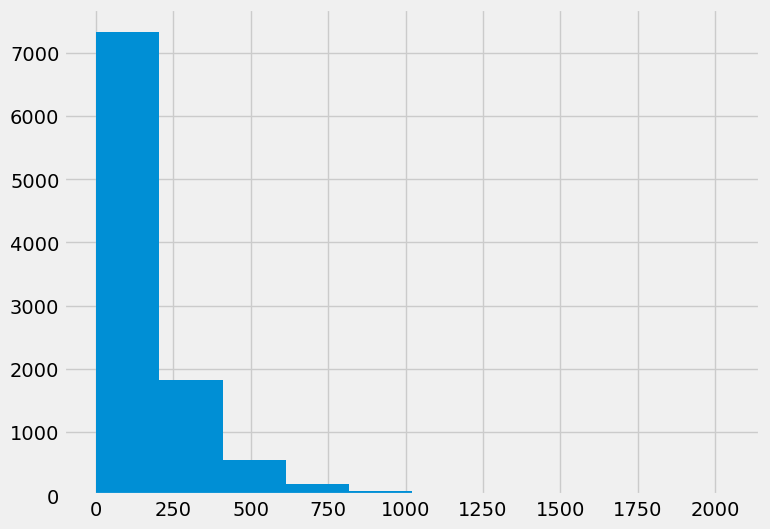

In [24]:
data['Total Amount on Account'].hist()

<AxesSubplot: >

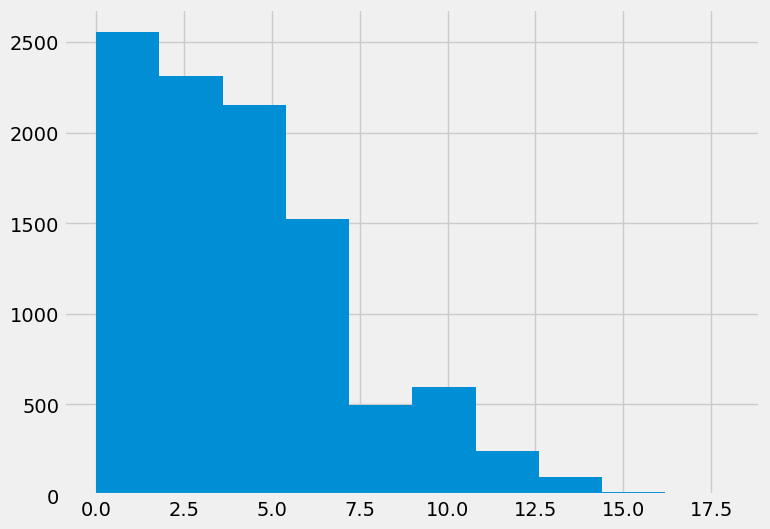

In [25]:
data['Years of Education'].hist()

The above histograms show no outliers. It is interesting that the distribution of 'Weeks since Beneficiary Account Creation' is prettty much uniform. There are several numerical variables which are not normally distributed, e.g. 'Total Amount on Account' or 'Years of Education'. 

For exploratory data analysis purposes, we will divide the original dataset into two subsets: one that corresponds to legit transactions, and another that corresponds to scams

In [26]:
no_scam = scam_data[scam_data['Scam'] == 0]
scam = scam_data[scam_data['Scam'] == 1]

In [27]:
no_scam.drop(columns=target_name, inplace=True)
scam.drop(columns=target_name, inplace=True)

### 2.3.3.- Comparison between 'scam' and 'no scam' for categorical features

In [28]:
no_scam_categorical = no_scam[categorical_columns]
scam_categorical = scam[categorical_columns]

In [29]:
no_scam_categorical['Location'].value_counts()*100/no_scam_categorical.shape[0]

Home    89.978829
Away    10.021171
Name: Location, dtype: float64

In [30]:
scam_categorical['Location'].value_counts()*100/scam_categorical.shape[0]

Home    70.37037
Away    29.62963
Name: Location, dtype: float64

There is a difference in 'Location' between the 'scam' and 'no scam' cases. A larger dataset would be useful to determine if this difference is significant

In [31]:
no_scam_categorical['Occupation'].value_counts()*100/no_scam_categorical.shape[0]

Other                 91.561649
Financial Services     5.686057
IT                     2.752294
Name: Occupation, dtype: float64

In [32]:
scam_categorical['Occupation'].value_counts()*100/scam_categorical.shape[0]

Other                 97.530864
Financial Services     2.469136
Name: Occupation, dtype: float64

In [33]:
type(scam_categorical['Occupation'].value_counts())

pandas.core.series.Series

There are no values corresponding to Occupation = IT in the 'scam' case. This is going to be an issue when evaluating the model, and thus previsions need to be taken when encoding categorical variables. A larger dataset would also be benficial here. 

We will produce bar plots in order to compare proportions of these categories across the two scenarios of interest.

In [34]:
location = pd.DataFrame()
location = location.append(no_scam_categorical['Location'].value_counts()*100/no_scam_categorical.shape[0], 
                           ignore_index=True)
location = location.append(scam_categorical['Location'].value_counts()*100/scam_categorical.shape[0], 
                           ignore_index=True)

/var/folders/mg/cy8d0_5j43dby62spsm5ltq80000gp/T/ipykernel_19074/3721185334.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  location = location.append(no_scam_categorical['Location'].value_counts()*100/no_scam_categorical.shape[0],
/var/folders/mg/cy8d0_5j43dby62spsm5ltq80000gp/T/ipykernel_19074/3721185334.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  location = location.append(scam_categorical['Location'].value_counts()*100/scam_categorical.shape[0],


In [35]:
location['idx'] = ['no scam', 'scam']

In [36]:
location.head()

,Home,Away,idx
0,89.978829,10.021171,no scam
1,70.370370,29.629630,scam


Text(0.5, 1.0, 'Location')

<Figure size 1000x800 with 0 Axes>

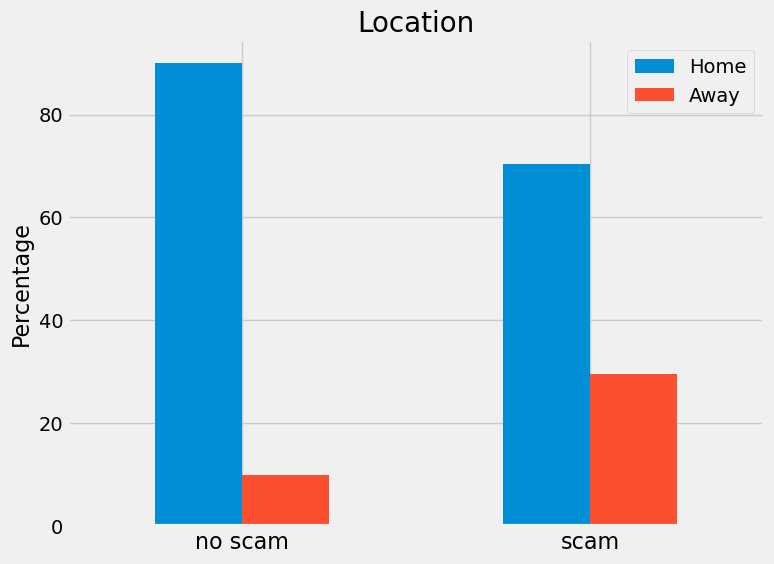

In [37]:
plt.figure(figsize=(10,8))
location.plot.bar(x='idx')
plt.ylabel('Percentage', fontsize=16)
plt.xlabel('')
plt.xticks(rotation = 0, fontsize=16)
plt.title('Location', fontsize=20)

As seen above, scams are associated with more transactions made from an "away" location. We will verify this conclusion through hypothesis testing.

In [38]:
from scipy.stats import chi2_contingency

table = location.iloc[:,0:2].values

alpha = 0.05

test_statistic, p_value, dof, expected = chi2_contingency(table)
if p_value <= alpha:
    print('scam transactions depend on location (reject H0)')
else:
    print('scam transactions do not depend on location (fail to reject H0)')
    
print('The p-value is ', p_value)    

scam transactions depend on location (reject H0)
The p-value is  0.0009654860737037522


In [39]:
occupation = pd.DataFrame()
occupation = occupation.append(no_scam_categorical['Occupation'].value_counts()*100/no_scam_categorical.shape[0], 
                               ignore_index=True)
occupation = occupation.append(scam_categorical['Occupation'].value_counts()*100/scam_categorical.shape[0], 
                               ignore_index=True)

/var/folders/mg/cy8d0_5j43dby62spsm5ltq80000gp/T/ipykernel_19074/2524114189.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  occupation = occupation.append(no_scam_categorical['Occupation'].value_counts()*100/no_scam_categorical.shape[0],
/var/folders/mg/cy8d0_5j43dby62spsm5ltq80000gp/T/ipykernel_19074/2524114189.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  occupation = occupation.append(scam_categorical['Occupation'].value_counts()*100/scam_categorical.shape[0],


In [40]:
occupation['idx'] = ['no scam', 'scam']

In [41]:
occupation.head()

,Other,Financial Services,IT,idx
0,91.561649,5.686057,2.752294,no scam
1,97.530864,2.469136,NaN,scam


Text(0.5, 1.0, 'Occupation')

<Figure size 1000x800 with 0 Axes>

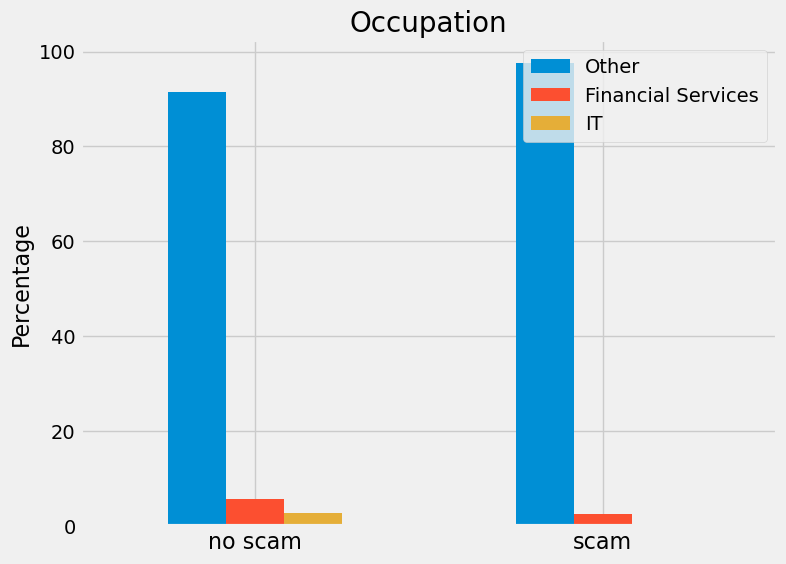

In [42]:
plt.figure(figsize=(10,8))
occupation.plot.bar(x='idx')
plt.ylabel('Percentage', fontsize=16)
plt.xlabel('')
plt.xticks(rotation = 0, fontsize=16)
plt.title('Occupation', fontsize=20)

In [43]:
occupation.head()

,Other,Financial Services,IT,idx
0,91.561649,5.686057,2.752294,no scam
1,97.530864,2.469136,NaN,scam


In [44]:
from scipy.stats import chi2_contingency

table = occupation.iloc[:,0:3].values

alpha = 0.05

test_statistic, p_value, dof, expected = chi2_contingency(table)
if p_value <= alpha:
    print('scam transactions depend on occupation (reject H0)')
else:
    print('scam transactions do not depend on occupation (fail to reject H0)')
    
print('The p-value is ', p_value)    

scam transactions do not depend on occupation (fail to reject H0)
The p-value is  nan


No conclusion can be reached as there is no data for "Occupation = IT" in the scam scenario

### 2.3.4.- Comparison between 'scam' and 'no scam' for numerical features

[Text(1, 0, 'no scam'), Text(2, 0, 'scam')]

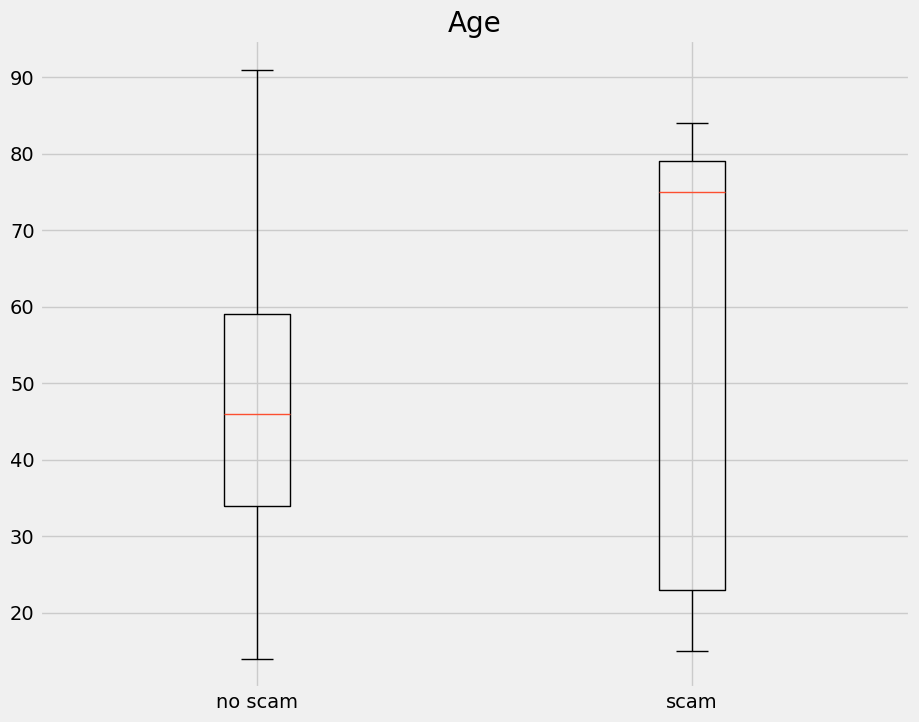

In [45]:
fig, ax = plt.subplots(figsize=(10,8))

plt.boxplot([no_scam['Age'], scam['Age']], 0, 'gD')

plt.title('Age', fontsize=20)

labels = ['no scam', 'scam']
ax.set_xticklabels(labels, fontsize=14)

Text(0.5, 1.0, 'Age')

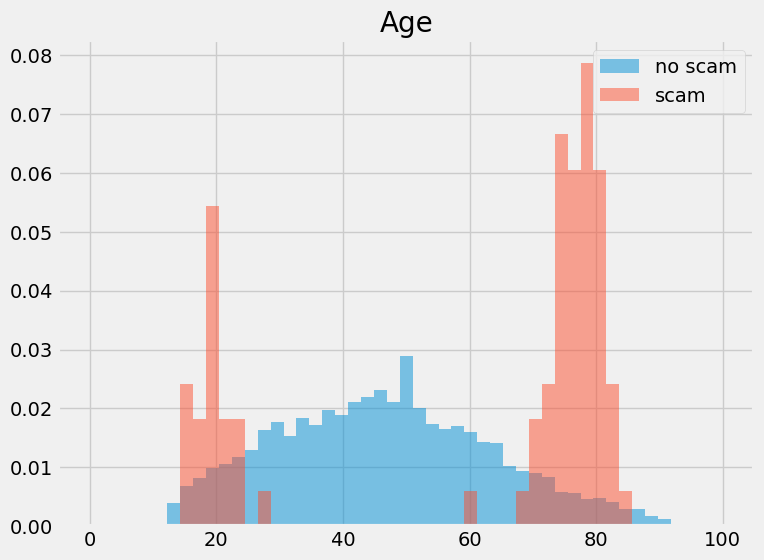

In [46]:
bins = np.linspace(0, 100, 50)

plt.hist(no_scam['Age'], bins, alpha=0.5, density=True, label='no scam')
plt.hist(scam['Age'], bins, alpha=0.5, density=True, label='scam')
plt.legend(loc='upper right')
plt.title('Age', fontsize=20)

There seems to be a significant difference in 'Age' between the 'scam' and 'no scam' cases

[Text(1, 0, 'no scam'), Text(2, 0, 'scam')]

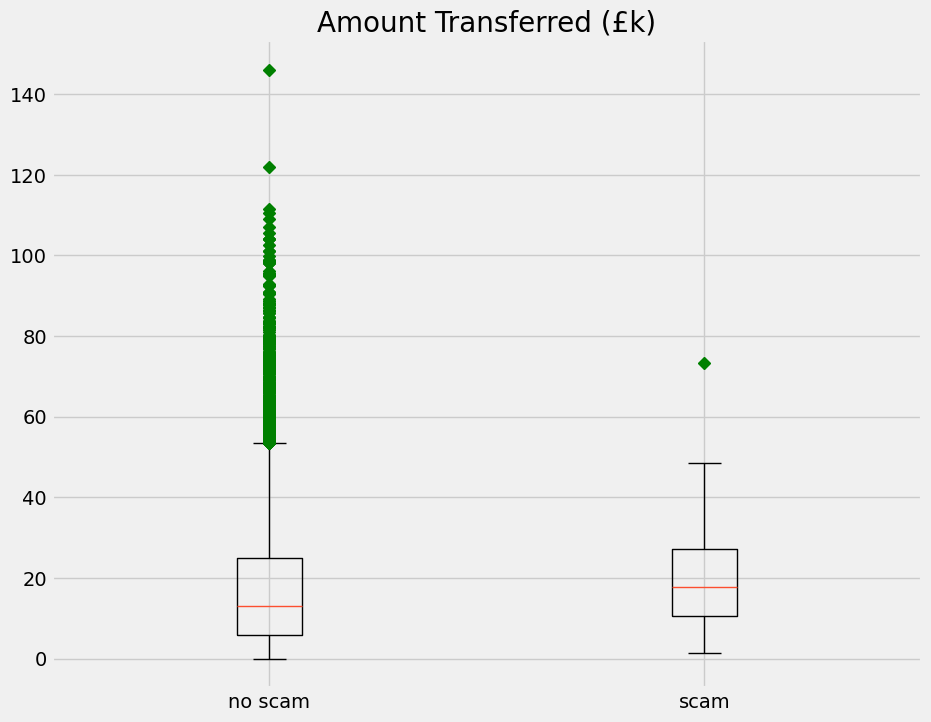

In [47]:
fig, ax = plt.subplots(figsize=(10,8))

plt.boxplot([no_scam['Amount Transferred (£k)'], scam['Amount Transferred (£k)']], 0, 'gD')

plt.title('Amount Transferred (£k)', fontsize=20)

labels = ['no scam', 'scam']
ax.set_xticklabels(labels, fontsize=14)

Many transactions for the 'no scam' case fall into the upper quartile of the distribution for 'Amount Transferred (£k)', that is not the case for the 'scam' case

Text(0.5, 1.0, 'Amount Transferred (£k)')

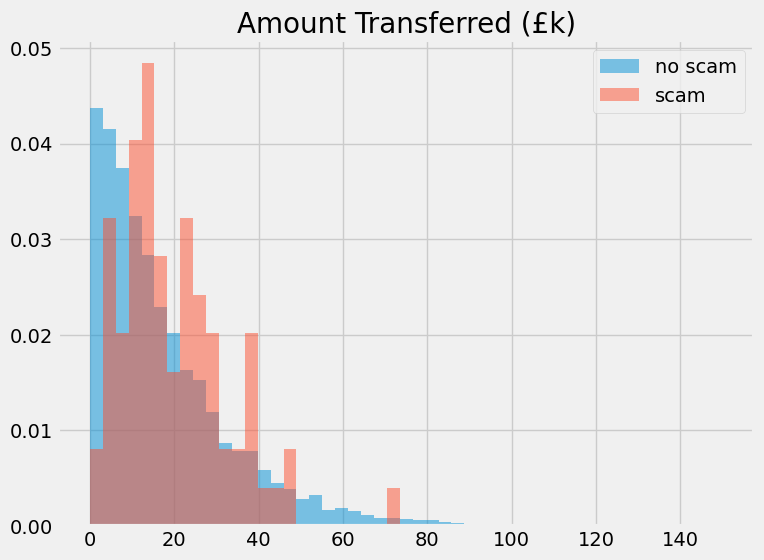

In [48]:
bins = np.linspace(0, 150, 50)

plt.hist(no_scam['Amount Transferred (£k)'], bins, alpha=0.5, density=True, label='no scam')
plt.hist(scam['Amount Transferred (£k)'], bins, alpha=0.5, density=True, label='scam')
plt.legend(loc='upper right')
plt.title('Amount Transferred (£k)', fontsize=20)

[Text(1, 0, 'no scam'), Text(2, 0, 'scam')]

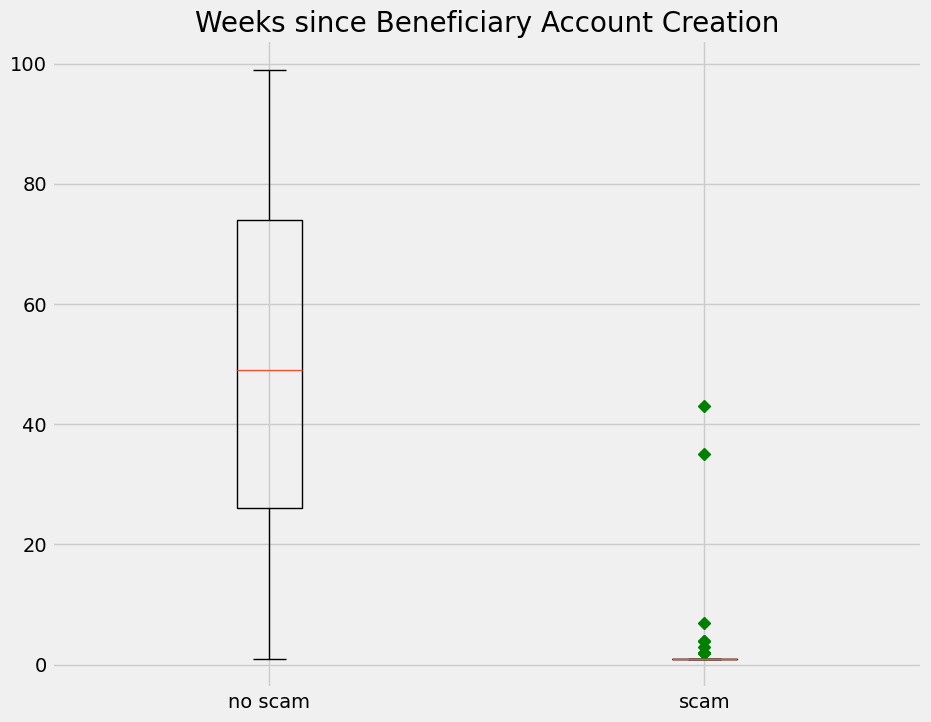

In [49]:
fig, ax = plt.subplots(figsize=(10,8))

plt.boxplot([no_scam['Weeks since Beneficiary Account Creation'], scam['Weeks since Beneficiary Account Creation']], 0, 'gD')

plt.title('Weeks since Beneficiary Account Creation', fontsize=20)

labels = ['no scam', 'scam']
ax.set_xticklabels(labels, fontsize=14)

Text(0.5, 1.0, 'Weeks since Beneficiary Account Creation')

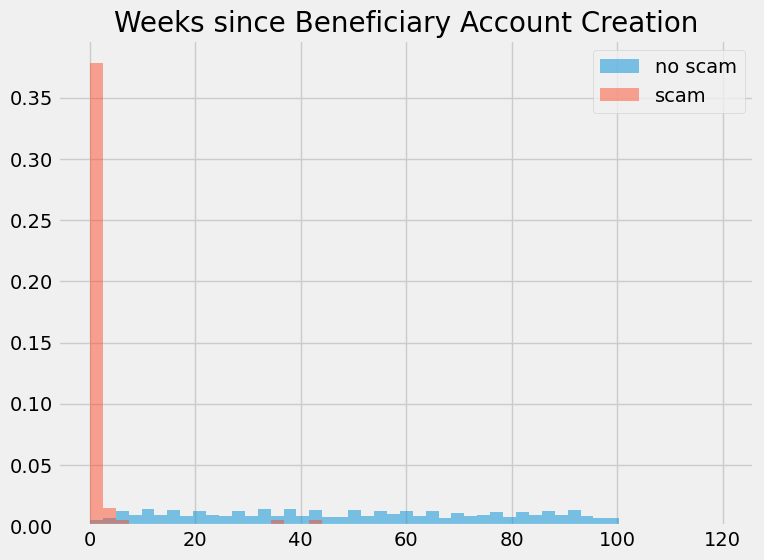

In [50]:
bins = np.linspace(0, 120, 50)

plt.hist(no_scam['Weeks since Beneficiary Account Creation'], bins, alpha=0.5, density=True, label='no scam')
plt.hist(scam['Weeks since Beneficiary Account Creation'], bins, alpha=0.5, density=True, label='scam')
plt.legend(loc='upper right')
plt.title('Weeks since Beneficiary Account Creation', fontsize=20)

There is a very clear difference between the 'scam' and 'no scam' cases in the distribution of 'Weeks since Beneficiary Account Creation': many scams take place a short time after the account has been created

[Text(1, 0, 'no scam'), Text(2, 0, 'scam')]

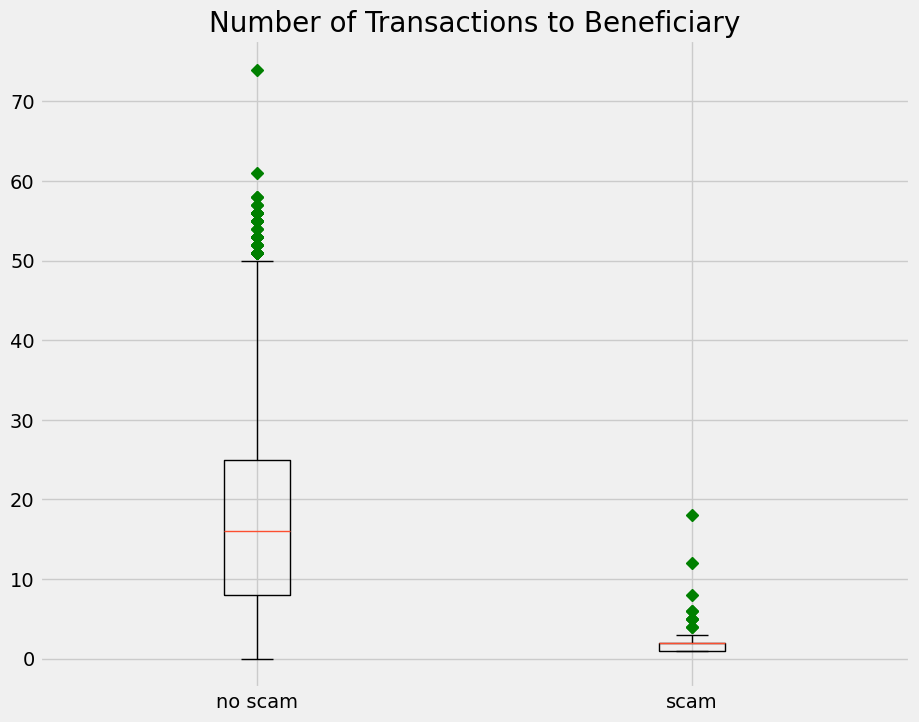

In [51]:
fig, ax = plt.subplots(figsize=(10,8))

plt.boxplot([no_scam['Number of Transactions to Beneficiary'], scam['Number of Transactions to Beneficiary']], 0, 'gD')

plt.title('Number of Transactions to Beneficiary', fontsize=20)

labels = ['no scam', 'scam']
ax.set_xticklabels(labels, fontsize=14)

Text(0.5, 1.0, 'Number of Transactions to Beneficiary')

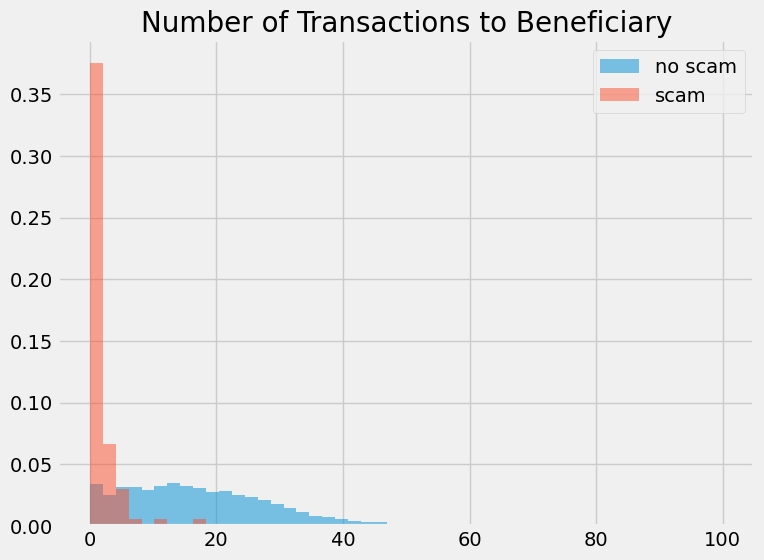

In [52]:
bins = np.linspace(0, 100, 50)

plt.hist(no_scam['Number of Transactions to Beneficiary'], bins, alpha=0.5, density=True, label='no scam')
plt.hist(scam['Number of Transactions to Beneficiary'], bins, alpha=0.5, density=True, label='scam')
plt.legend(loc='upper right')
plt.title('Number of Transactions to Beneficiary', fontsize=20)

Again, very clear difference between distributions for 'Number of Transactions to Beneficiary': in the scam case this number is rather low as compared to the 'no scam' scenario

[Text(1, 0, 'no scam'), Text(2, 0, 'scam')]

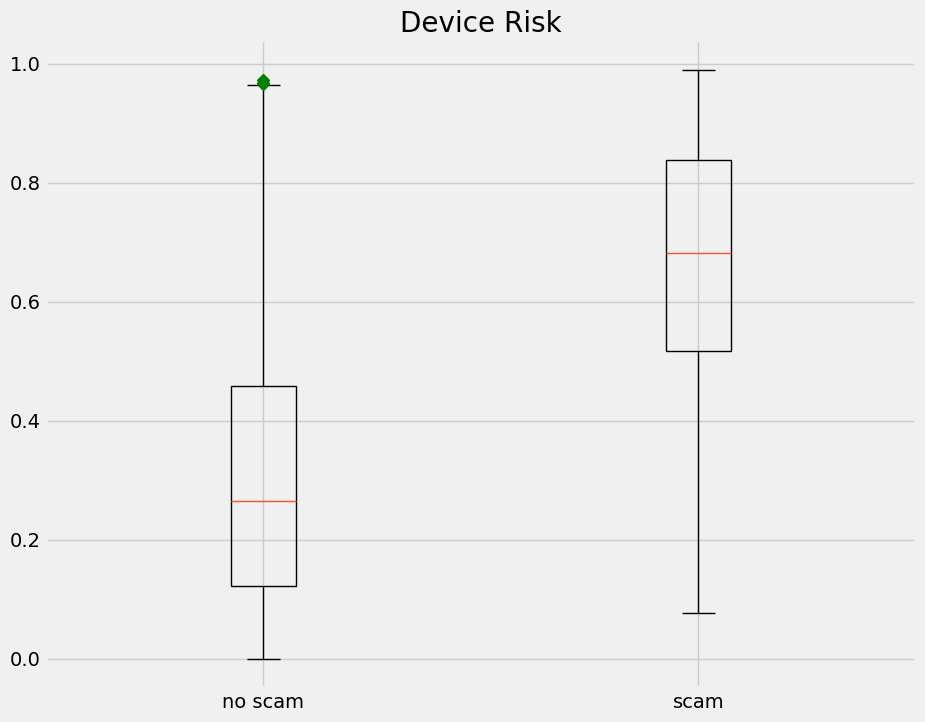

In [53]:
fig, ax = plt.subplots(figsize=(10,8))

plt.boxplot([no_scam['Device Risk'], scam['Device Risk']], 0, 'gD')

plt.title('Device Risk', fontsize=20)

labels = ['no scam', 'scam']
ax.set_xticklabels(labels, fontsize=14)

Text(0.5, 1.0, 'Device Risk')

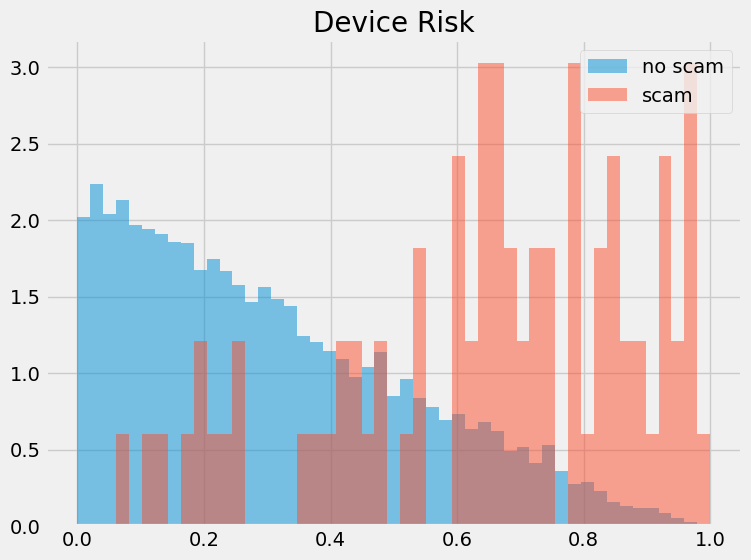

In [54]:
bins = np.linspace(0, 1, 50)

plt.hist(no_scam['Device Risk'], bins, alpha=0.5, density=True, label='no scam')
plt.hist(scam['Device Risk'], bins, alpha=0.5, density=True, label='scam')
plt.legend(loc='upper right')
plt.title('Device Risk', fontsize=20)

Evidently there is a marked difference between the distributions of 'Device Risk' for the 'scam' and 'no scam' cases

[Text(1, 0, 'no scam'), Text(2, 0, 'scam')]

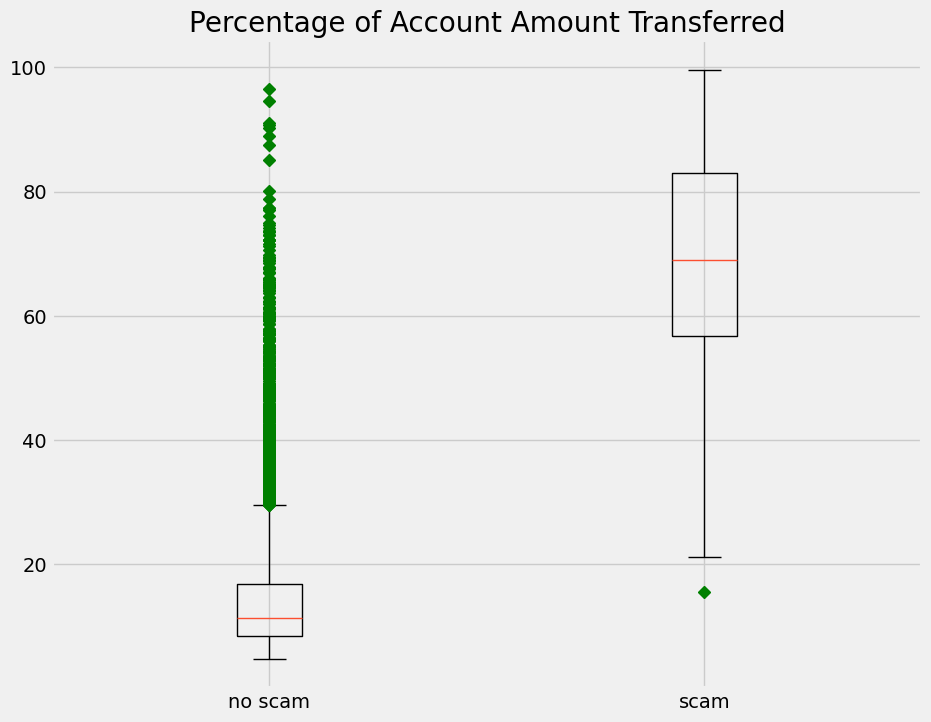

In [55]:
fig, ax = plt.subplots(figsize=(10,8))

plt.boxplot([no_scam['Percentage of Account Amount Transferred'], scam['Percentage of Account Amount Transferred']], 0, 'gD')

plt.title('Percentage of Account Amount Transferred', fontsize=20)

labels = ['no scam', 'scam']
ax.set_xticklabels(labels, fontsize=14)

Text(0.5, 1.0, 'Percentage of Account Amount Transferred')

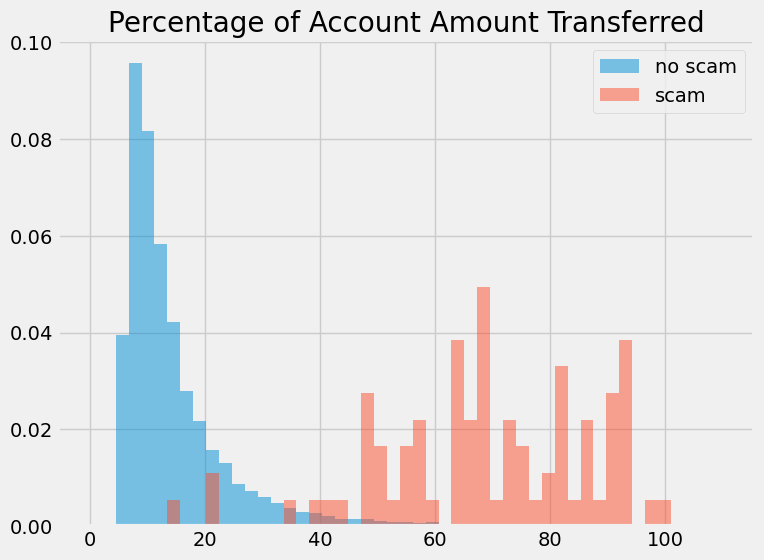

In [56]:
bins = np.linspace(0, 110, 50)

plt.hist(no_scam['Percentage of Account Amount Transferred'], bins, alpha=0.5, density=True, label='no scam')
plt.hist(scam['Percentage of Account Amount Transferred'], bins, alpha=0.5, density=True, label='scam')
plt.legend(loc='upper right')
plt.title('Percentage of Account Amount Transferred', fontsize=20)

Marked difference between the distributions of 'Percentage of Account Amount Transferred' - a large percentage of the account amount is transferred in the 'scam' case - this is understandable as the intent would be to empty the victim's account.

[Text(1, 0, 'no scam'), Text(2, 0, 'scam')]

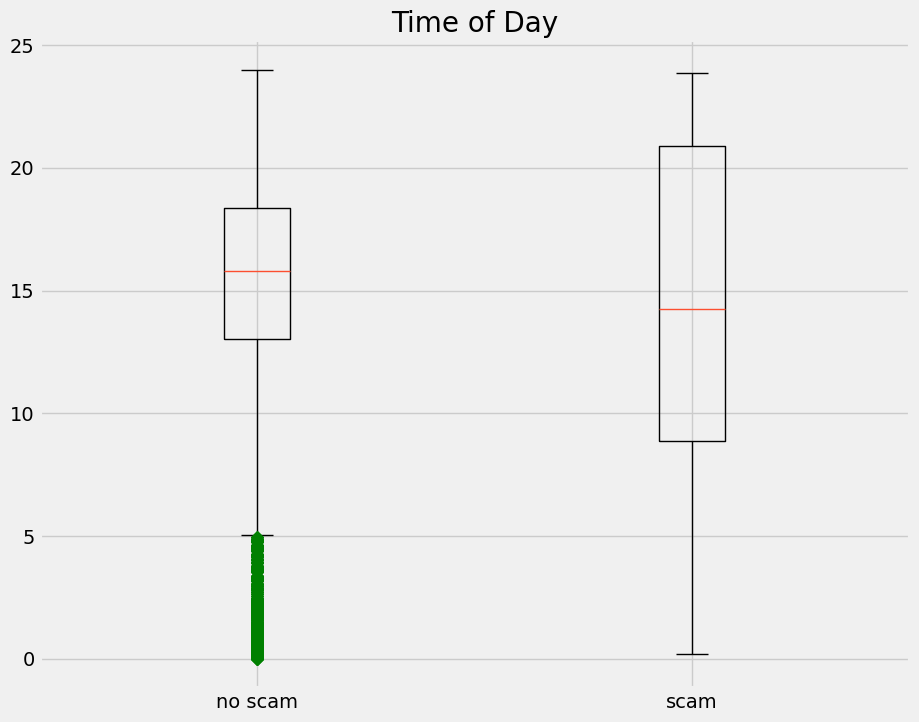

In [57]:
fig, ax = plt.subplots(figsize=(10,8))

plt.boxplot([no_scam['Time of Day'], scam['Time of Day']], 0, 'gD')

plt.title('Time of Day', fontsize=20)

labels = ['no scam', 'scam']
ax.set_xticklabels(labels, fontsize=14)

Text(0.5, 1.0, 'Time of Day')

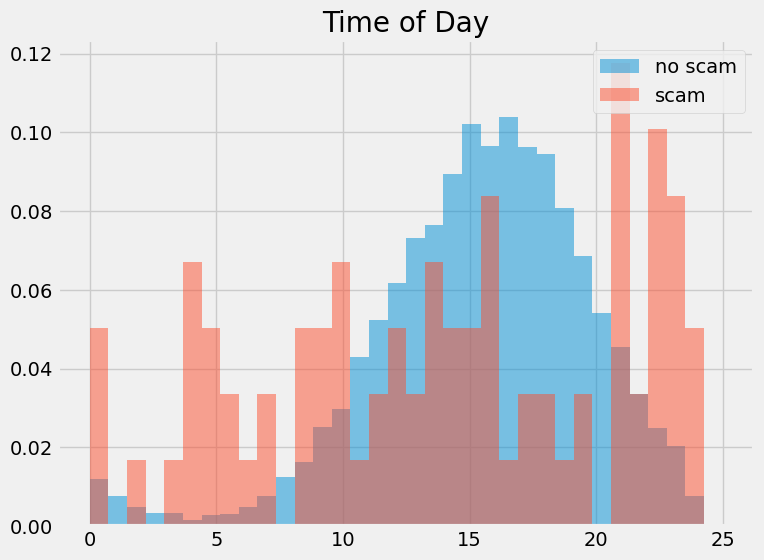

In [242]:
bins = np.linspace(0, 25, 35)

plt.hist(no_scam['Time of Day'], bins, alpha=0.5, density=True, label='no scam')
plt.hist(scam['Time of Day'], bins, alpha=0.5, density=True, label='scam')
plt.legend(loc='upper right')
plt.title('Time of Day', fontsize=20)

There is a difference in the distribution of 'Time of Day' for the 'scam' and 'no scam' cases

[Text(1, 0, 'no scam'), Text(2, 0, 'scam')]

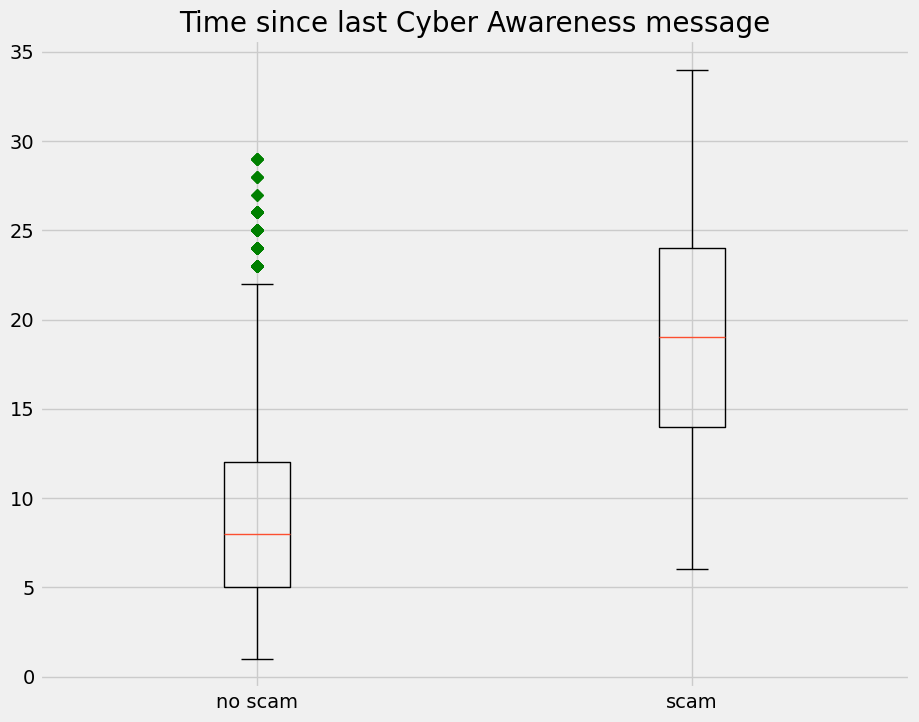

In [59]:
fig, ax = plt.subplots(figsize=(10,8))

plt.boxplot([no_scam['Time since last Cyber Awareness message'], scam['Time since last Cyber Awareness message']], 0, 'gD')

plt.title('Time since last Cyber Awareness message', fontsize=20)

labels = ['no scam', 'scam']
ax.set_xticklabels(labels, fontsize=14)

Text(0.5, 1.0, 'Time since last Cyber Awareness message')

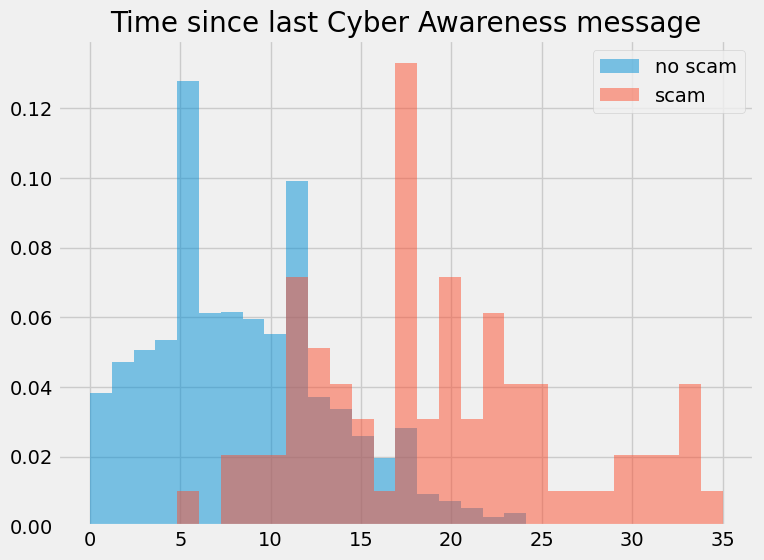

In [240]:
bins = np.linspace(0, 35, 30)

plt.hist(no_scam['Time since last Cyber Awareness message'], bins, alpha=0.5, density=True, label='no scam')
plt.hist(scam['Time since last Cyber Awareness message'], bins, alpha=0.5, density=True, label='scam')
plt.legend(loc='upper right')
plt.title('Time since last Cyber Awareness message', fontsize=20)

Marked difference between the distributions of this feature for the two considered scenarios

[Text(1, 0, 'no scam'), Text(2, 0, 'scam')]

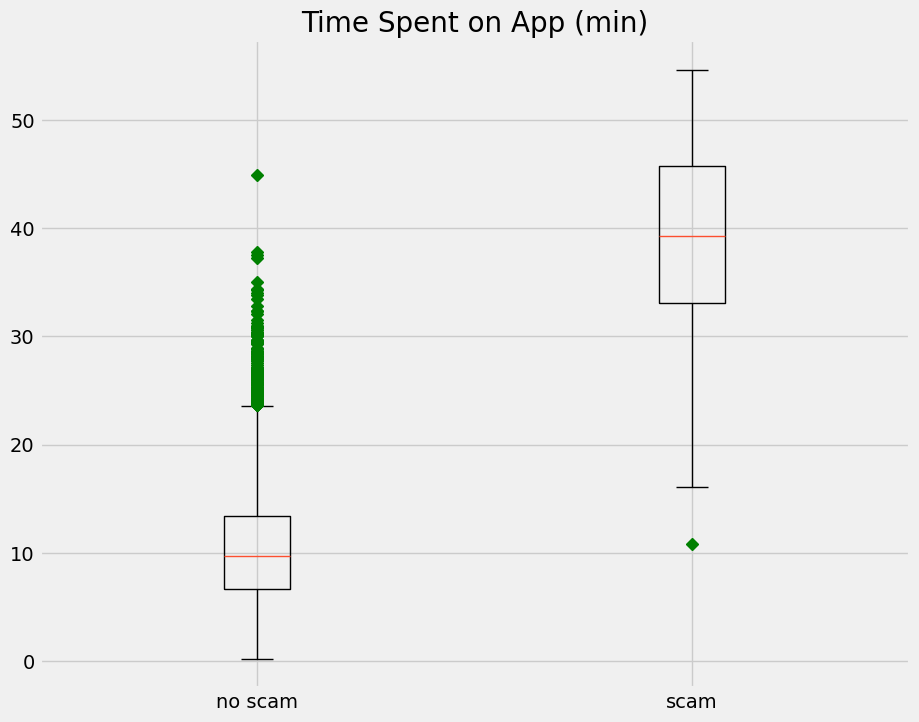

In [61]:
fig, ax = plt.subplots(figsize=(10,8))

plt.boxplot([no_scam['Time Spent on App (min)'], scam['Time Spent on App (min)']], 0, 'gD')

plt.title('Time Spent on App (min)', fontsize=20)

labels = ['no scam', 'scam']
ax.set_xticklabels(labels, fontsize=14)

Text(0.5, 1.0, 'Time Spent on App (min)')

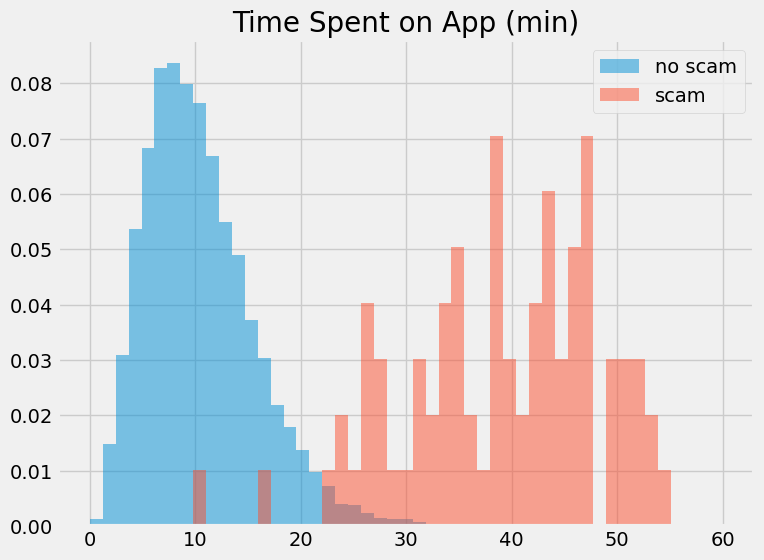

In [62]:
bins = np.linspace(0, 60, 50)

plt.hist(no_scam['Time Spent on App (min)'], bins, alpha=0.5, density=True, label='no scam')
plt.hist(scam['Time Spent on App (min)'], bins, alpha=0.5, density=True, label='scam')
plt.legend(loc='upper right')
plt.title('Time Spent on App (min)', fontsize=20)

Clear difference between distributions - this is a promising feature for prediction purposes.

[Text(1, 0, 'no scam'), Text(2, 0, 'scam')]

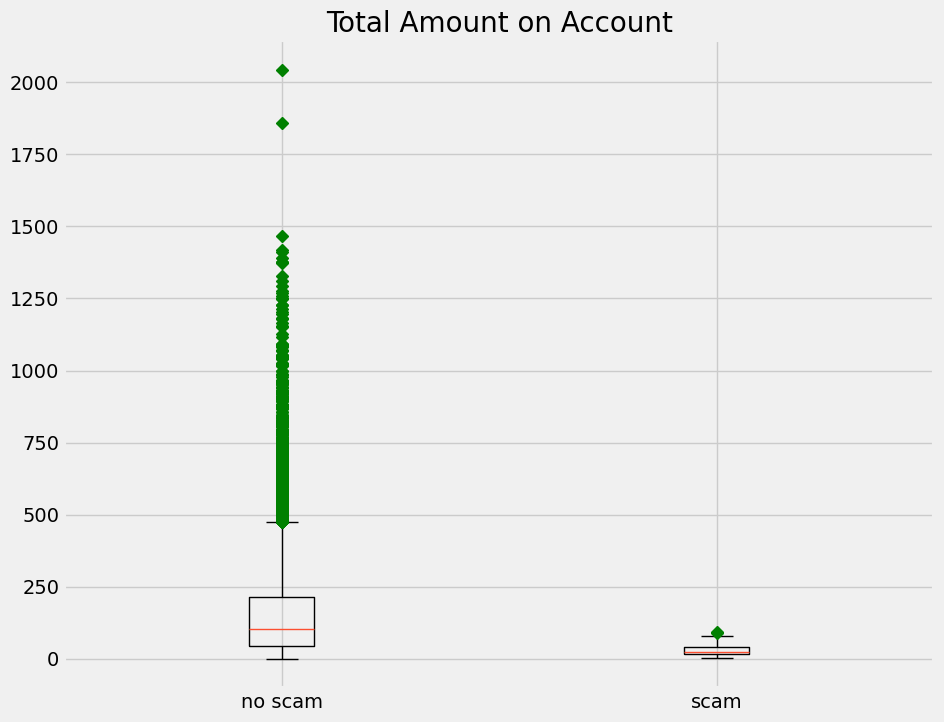

In [63]:
fig, ax = plt.subplots(figsize=(10,8))

plt.boxplot([no_scam['Total Amount on Account'], scam['Total Amount on Account']], 0, 'gD')

plt.title('Total Amount on Account', fontsize=20)

labels = ['no scam', 'scam']
ax.set_xticklabels(labels, fontsize=14)

Text(0.5, 1.0, 'Total Amount on Account')

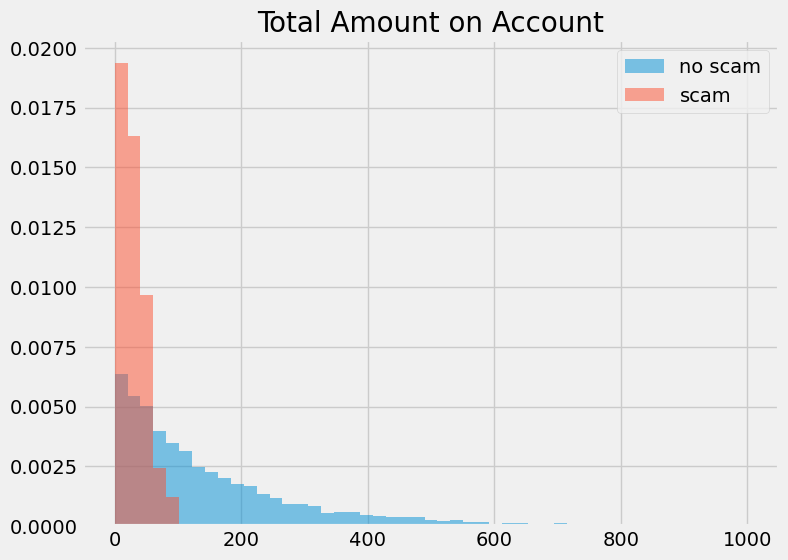

In [64]:
bins = np.linspace(0, 1000, 50)

plt.hist(no_scam['Total Amount on Account'], bins, alpha=0.5, density=True, label='no scam')
plt.hist(scam['Total Amount on Account'], bins, alpha=0.5, density=True, label='scam')
plt.legend(loc='upper right')
plt.title('Total Amount on Account', fontsize=20)

The 'Total Amount on Account' seems to be smaller in the 'scam' cases

[Text(1, 0, 'no scam'), Text(2, 0, 'scam')]

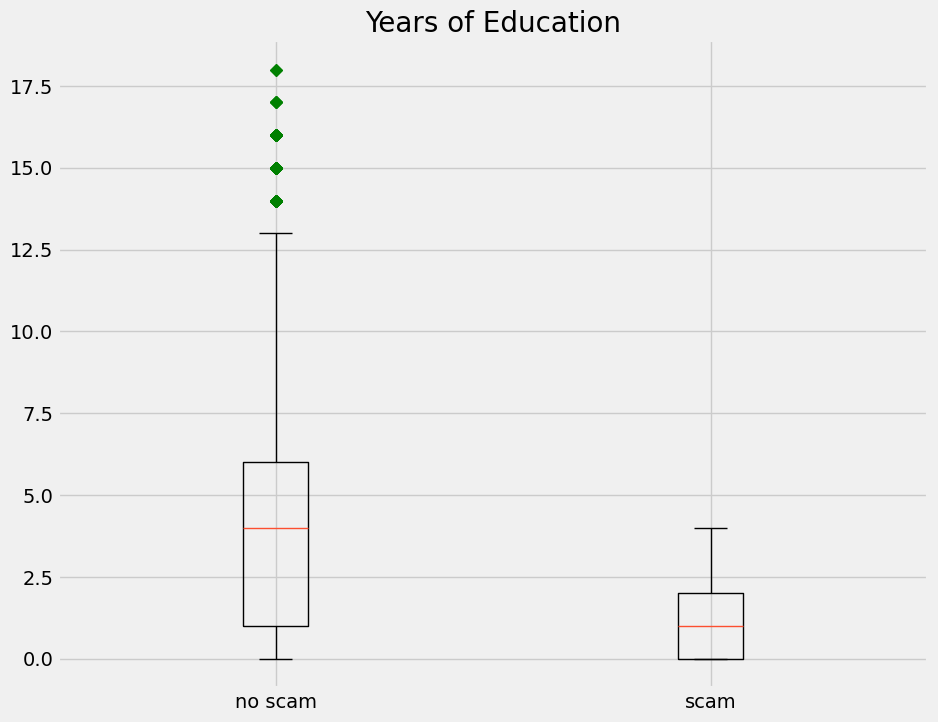

In [65]:
fig, ax = plt.subplots(figsize=(10,8))

plt.boxplot([no_scam['Years of Education'], scam['Years of Education']], 0, 'gD')

plt.title('Years of Education', fontsize=20)

labels = ['no scam', 'scam']
ax.set_xticklabels(labels, fontsize=14)

Text(0.5, 1.0, 'Years of Education')

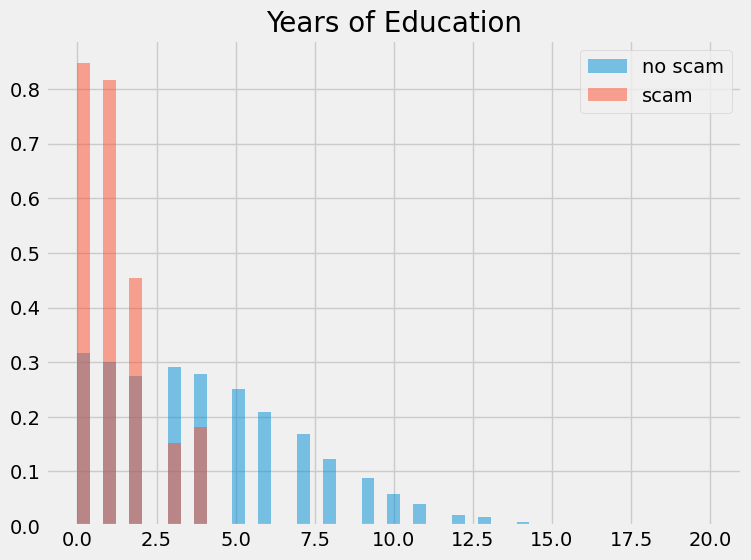

In [66]:
bins = np.linspace(0, 20, 50)

plt.hist(no_scam['Years of Education'], bins, alpha=0.5, density=True, label='no scam')
plt.hist(scam['Years of Education'], bins, alpha=0.5, density=True, label='scam')
plt.legend(loc='upper right')
plt.title('Years of Education', fontsize=20)

Apparently scammers have a smaller number of 'Years of Education'

**From the above analysis it is apparent that there are quite a few features that provide a clear differentiation between the 'scam' and 'no scam' cases - having a larger dataset would help us confirm these findings.**

# 3. Model training

We will now train a machine learning model to predict if a transaction will be a scam. At this stage we will chose a tree-based model, as they a) do not require numerical feature scaling and b) using an ordinal encoding for the categorical variables is fine even if the encoding results in an arbitrary ordering

First we will put together a machine learning pipeline for the model

In [131]:
from sklearn.model_selection import train_test_split

data_train, data_test, target_train, target_test = train_test_split(data, target, random_state=RANDOM_STATE)

In [210]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer

# as there are categories that are not present in the 'scam' case, we will set the 'handle_unknown'
# parameter for the ordinakl encoder
categorical_preprocessor = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)

# no preprocessing required for numerical variables 
preprocessor = ColumnTransformer(
    [('cat_preprocessor', categorical_preprocessor, selector(dtype_include=object))],
    remainder='passthrough', sparse_threshold=0)

In [211]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

model = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(random_state=RANDOM_STATE))
])

There are quite a few hyperparameters that can be tuned in a random forest classifier - for the sake to time we will only tune the number of trees in the forest and their maximum depth. A nested cross validation approach will be used.

In [212]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'classifier__n_estimators': (1, 2),
    'classifier__max_depth': (1, 2)
}

model_grid_search = GridSearchCV(model, param_grid=param_grid, n_jobs=2, cv=5)

A good metric for classification tasks is log loss, as it not only penalises wrong predictions but also predictions which are not confident (in other words, predictions that do not lean clearly towards 0 or 1). A lower log loss means a more acurate model.

In [213]:
from sklearn.model_selection import cross_validate

cv_results = cross_validate(model_grid_search, data_train, target_train, cv=5, scoring='neg_log_loss', n_jobs=2, 
                            return_train_score=True, error_score="raise", return_estimator=True)

In [214]:
cv_results_DF = pd.DataFrame(cv_results)
cv_results_DF.head()

,fit_time,score_time,estimator,test_score,train_score
0,0.294243,0.003869,"GridSearchCV(cv=5,\n estimator=Pip...",-0.019866,-0.021289
1,0.285676,0.003998,"GridSearchCV(cv=5,\n estimator=Pip...",-0.079999,-0.026723
2,0.266055,0.003953,"GridSearchCV(cv=5,\n estimator=Pip...",-0.010073,-0.009603
3,0.266352,0.003906,"GridSearchCV(cv=5,\n estimator=Pip...",-0.010434,-0.009769
4,0.262707,0.003610,"GridSearchCV(cv=5,\n estimator=Pip...",-0.010849,-0.011085


The above results are reassuring as the train and test scores are quite close.

In [216]:
print(f"The average logloss is "
      f"{cv_results['test_score'].mean():.3f} +/-" \
      f"{cv_results['test_score'].std():.3f}")

The average logloss is -0.026 +/-0.027


In [217]:
for cv_fold, estimator_in_fold in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for fold #{cv_fold + 1}:\n"
        f"{estimator_in_fold.best_params_}"
    )

Best hyperparameters for fold #1:
{'classifier__max_depth': 2, 'classifier__n_estimators': 1}
Best hyperparameters for fold #2:
{'classifier__max_depth': 2, 'classifier__n_estimators': 1}
Best hyperparameters for fold #3:
{'classifier__max_depth': 2, 'classifier__n_estimators': 2}
Best hyperparameters for fold #4:
{'classifier__max_depth': 2, 'classifier__n_estimators': 2}
Best hyperparameters for fold #5:
{'classifier__max_depth': 2, 'classifier__n_estimators': 2}


We thus see that a forest with 2 trees and max_depth = 2 is good enough for our dataset.

In [218]:
model = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(n_estimators = 2, max_depth=2, random_state=RANDOM_STATE))
])

In [219]:
model.fit(data_train, target_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('cat_preprocessor',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc1da965a60>)])),
                ('classifier',
                 RandomForestClassifier(max_depth=2, n_estimators=2,
                                        random_state=801))])

## 3.1.- Performance on test set

In order to select a suitable decision threshold for our classification model, we will first generate a precision-recall plot:

In [222]:
probas = model.predict_proba(data_test)[:, 1]

In [223]:
from sklearn.metrics import precision_recall_curve, precision_score, recall_score

precision, recall, thresholds = precision_recall_curve(target_test, probas)

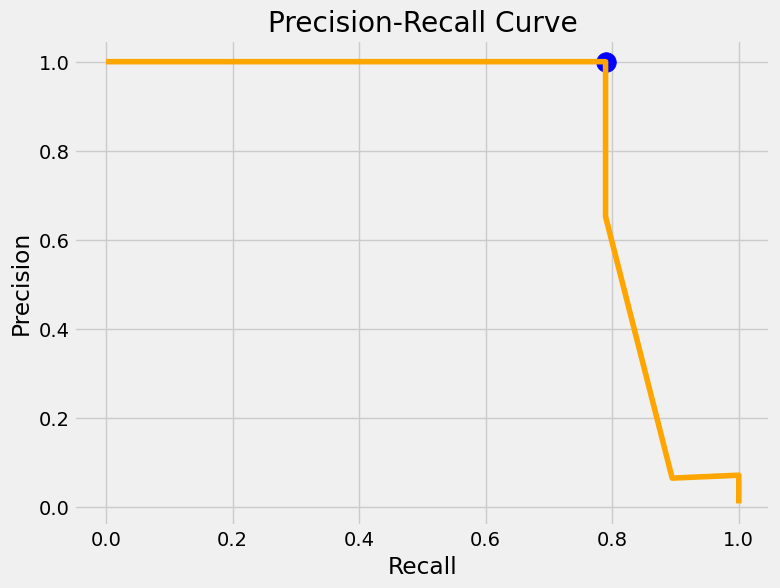

In [239]:
#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='orange')

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

ax.scatter(recall[6], precision[6], s=200, c='b', marker='o', label="Threshold =" )

We have an unrealistically good dataset, precision is one for a large range of thresholds. We will select the decision threshold corresponding to the blue dot in the precision-recall curve.

In [244]:
thresholds[6]

0.5

In [245]:
threshold = thresholds[6]
predictions = [1 if probas[k] >= threshold else 0 for k in np.arange(len(probas))]

In [252]:
precision_score(target_test, predictions)

1.0

The model can generate perfect predictions for scams - no false positives. 

In [253]:
recall_score(target_test, predictions, )

0.7894736842105263

The model can identify 79% of the scams

In [254]:
from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(target_test, predictions)
confusion

array([[2481,    0],
       [   4,   15]])

Text(0.5, 1.0, 'Random Forest Model')

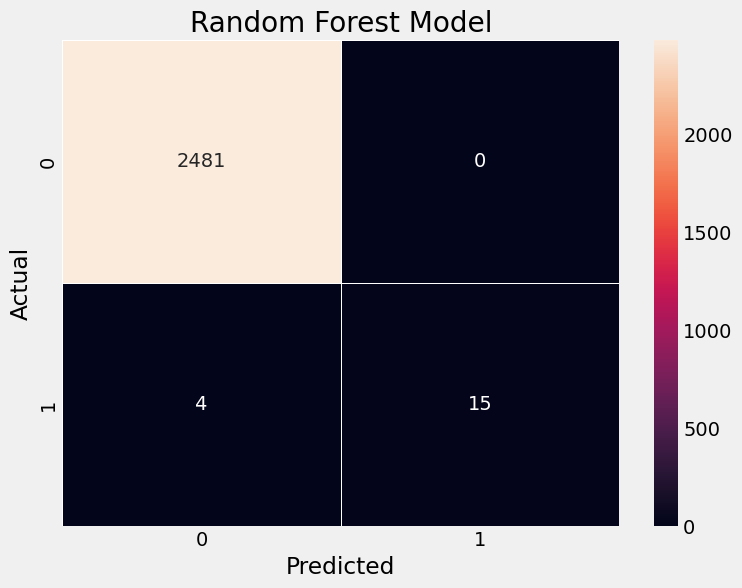

In [255]:
fig, ax = plt.subplots(figsize=(8,6))
ax = sns.heatmap(confusion, annot=True, fmt="d", linewidths=.5)
ax.set(xlabel='Predicted', ylabel='Actual')
ax.set_title('Random Forest Model')

The confusion matrix looks quite good - no false positives, only four false negatives out of 2500 predictions

## 3.2.- Feature importances

### 3.2.1.- Random forest feature importances

In [256]:
feature_importances = pd.DataFrame(model[-1].feature_importances_,
                                   index = data.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

In [257]:
feature_importances

,importance
Device Risk,0.343720
Time of Day,0.186584
Percentage of Account Amount Transferred,0.177919
Time Spent on App (min),0.156938
Location,0.134839
Age,0.000000
Amount Transferred (£k),0.000000
Weeks since Beneficiary Account Creation,0.000000
Number of Transactions to Beneficiary,0.000000
Occupation,0.000000


<AxesSubplot: >

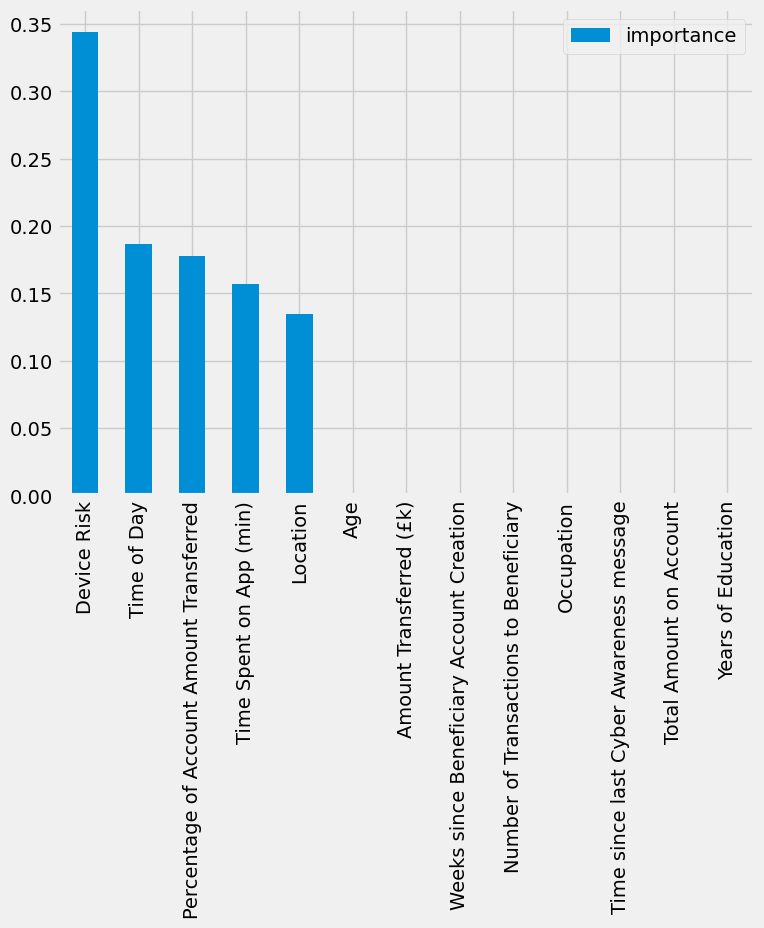

In [258]:
feature_importances.plot.bar()

### 3.2.2.- Permutation feature importances

In [259]:
from sklearn.inspection import permutation_importance

r = permutation_importance(model, data_test, target_test, n_repeats=30, random_state=RANDOM_STATE)

In [260]:
r_sub = dict((k, r[k]) for k in ('importances_mean', 'importances_std'))

In [261]:
permutation_importances_df = pd.DataFrame(r_sub)

In [262]:
permutation_importances_df['Features'] = data_test.columns

In [263]:
permutation_importances_df.sort_values(by='importances_mean', ascending=False, inplace=True)

In [264]:
permutation_importances_df

,importances_mean,importances_std,Features
2,0.005067,0.000215,Weeks since Beneficiary Account Creation
7,0.001227,0.000177,Percentage of Account Amount Transferred
10,0.001160,0.000348,Time Spent on App (min)
0,0.000000,0.000000,Age
1,0.000000,0.000000,Amount Transferred (£k)
4,0.000000,0.000000,Device Risk
5,0.000000,0.000000,Location
6,0.000000,0.000000,Occupation
8,0.000000,0.000000,Time of Day
9,0.000000,0.000000,Time since last Cyber Awareness message


<AxesSubplot: xlabel='Features'>

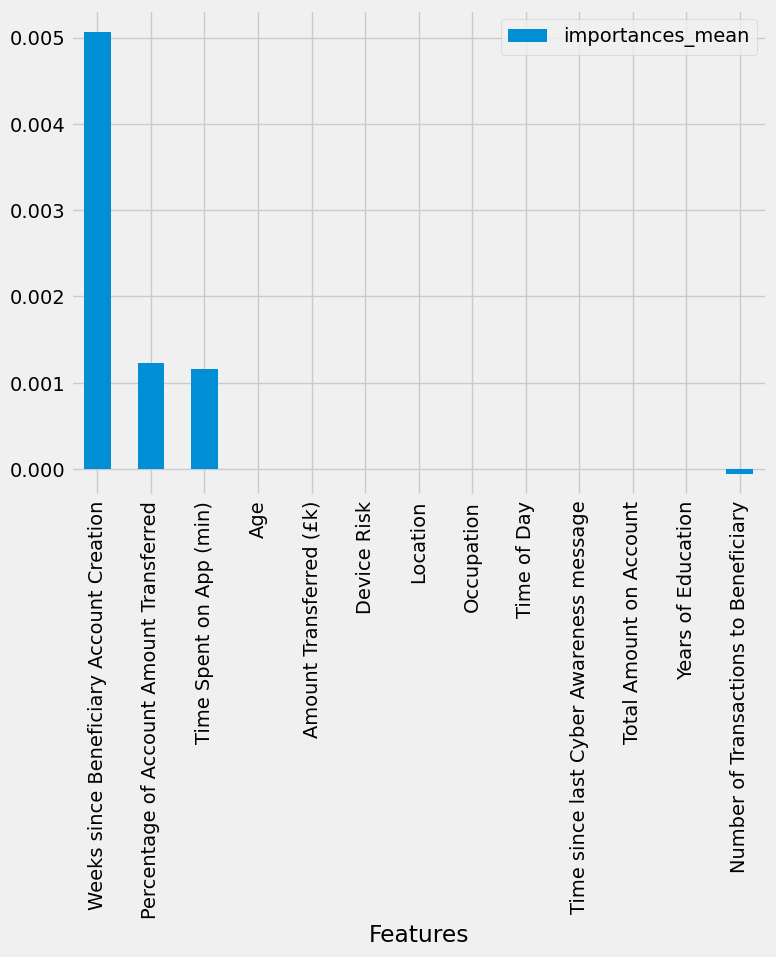

In [265]:
permutation_importances_df.plot.bar(x='Features', y = 'importances_mean')